In [12]:
# Code block for importing files and libraries

import os
from PIL import Image

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

In [13]:
# This code block is to download and use the dataset
# This block should be edited (config = "") when used


# import numpy as np
# import tensorflow as tf
# import tensorflow_datasets as tfds
# import matplotlib.pyplot as plt

# from tensorflow import keras
# from tensorflow.keras import layers

# AUTOTUNE = tf.data.AUTOTUNE

# # Download DIV2K from TF Datasets
# # Using bicubic 4x degradation type
# div2k_data = tfds.image.Div2k(config="bicubic_x8")
# div2k_data.download_and_prepare()

# # Taking train data from div2k_data object
# train = div2k_data.as_dataset(split="train", as_supervised=True)
# train_cache = train.cache()
# # Validation data
# val = div2k_data.as_dataset(split="validation", as_supervised=True)
# val_cache = val.cache()

In [14]:
# Code block if you have an already uploaded dataset to kaggle

# Directory paths for training data
train_hr_dir = '/kaggle/input/div2k-x8/DIV2K_x8/DIV2K_train_HR'
train_lr_dir = '/kaggle/input/div2k-x8/DIV2K_x8/DIV2K_train_LR_x8'

# Directory paths
val_hr_dir = '/kaggle/input/div2k-x8/DIV2K_x8/DIV2K_valid_HR'
val_lr_dir = '/kaggle/input/div2k-x8/DIV2K_x8/DIV2K_valid_LR_x8'


# Get list of image file paths for training HR and LR
train_hr_files = [os.path.join(train_hr_dir, f) for f in sorted(os.listdir(train_hr_dir))]
train_lr_files = [os.path.join(train_lr_dir, f) for f in sorted(os.listdir(train_lr_dir))]

# Get list of image file paths
val_hr_files = [os.path.join(val_hr_dir, f) for f in sorted(os.listdir(val_hr_dir))]
val_lr_files = [os.path.join(val_lr_dir, f) for f in sorted(os.listdir(val_lr_dir))]

# Function to load and preprocess images
def process_images(hr_file, lr_file):
    hr_image = tf.image.decode_image(tf.io.read_file(hr_file))
    lr_image = tf.image.decode_image(tf.io.read_file(lr_file))
    
    return lr_image, hr_image

# Create dataset
train_files = tf.data.Dataset.from_tensor_slices((train_hr_files, train_lr_files))
train = train_files.map(process_images)

# Create dataset
val_files = tf.data.Dataset.from_tensor_slices((val_hr_files, val_lr_files))
val = val_files.map(process_images)


train = train.prefetch(tf.data.experimental.AUTOTUNE)
val = val.prefetch(tf.data.experimental.AUTOTUNE)

# Cache the dataset
train_cache = train.cache()
val_cache = val.cache()

In [15]:
# Code block for image augmentation Data set creation and EDSR model

def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=192, scale=8):
    """Crop images.

    low resolution images: 24x24
    high resolution images: 96x96
    """
    lowres_crop_size = hr_crop_size // scale  # 96//4=24
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 24x24
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 96x96

    return lowres_img_cropped, highres_img_cropped


def dataset_object(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=8),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value


class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img
    


def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)

In [16]:
# Creating the Dataset

train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

In [17]:
# Creating the Model

model = make_model(num_filters=64, num_of_residual_blocks=16)

In [18]:
# Training the model

optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae", metrics=[PSNR])

model.fit(train_ds, epochs=200, steps_per_epoch=200, validation_data=val_ds)

Epoch 1/200
200/200 [==============================] - 57s 198ms/step - loss: 28.7682 - PSNR: 17.5360 - val_loss: 17.6865 - val_PSNR: 20.0846
Epoch 2/200
200/200 [==============================] - 8s 40ms/step - loss: 15.7669 - PSNR: 21.7945 - val_loss: 15.9184 - val_PSNR: 19.4657
Epoch 3/200
200/200 [==============================] - 8s 40ms/step - loss: 13.8672 - PSNR: 23.0414 - val_loss: 14.6140 - val_PSNR: 21.6268
Epoch 4/200
200/200 [==============================] - 8s 40ms/step - loss: 13.0419 - PSNR: 23.7327 - val_loss: 12.6886 - val_PSNR: 22.0778
Epoch 5/200
200/200 [==============================] - 8s 41ms/step - loss: 12.6594 - PSNR: 24.3160 - val_loss: 12.4031 - val_PSNR: 23.7034
Epoch 6/200
200/200 [==============================] - 8s 40ms/step - loss: 12.6680 - PSNR: 24.3343 - val_loss: 12.1942 - val_PSNR: 21.8534
Epoch 7/200
200/200 [==============================] - 8s 40ms/step - loss: 12.3910 - PSNR: 24.0826 - val_loss: 12.4727 - val_PSNR: 24.3887
Epoch 8/200
200/20

In [19]:
# # Using a pretrained model

# model.load_weights('<file path of the saved model in kaggle>')

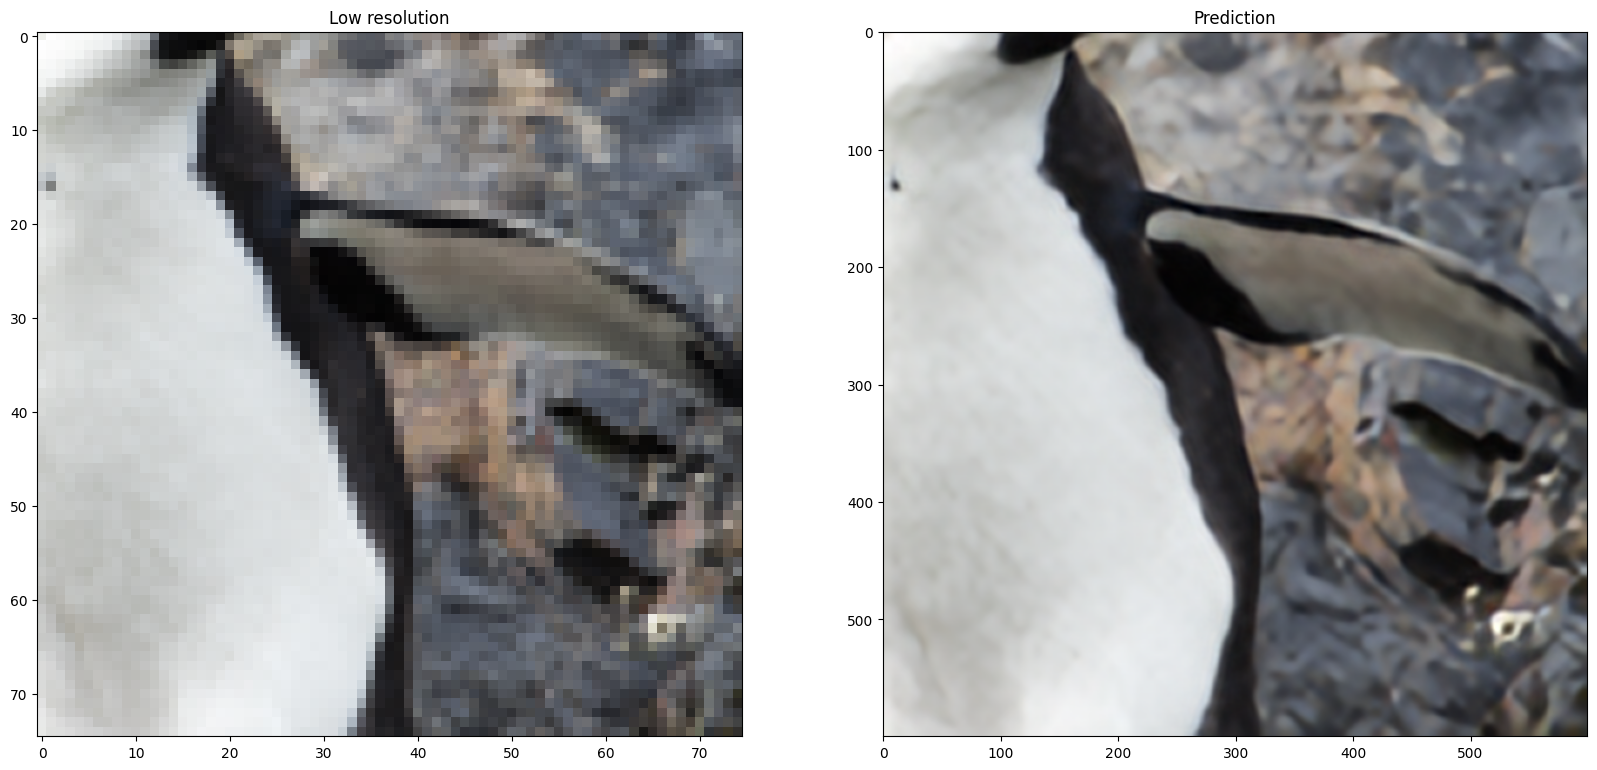

PSNR: 29.218935
SSIM: 0.79074574


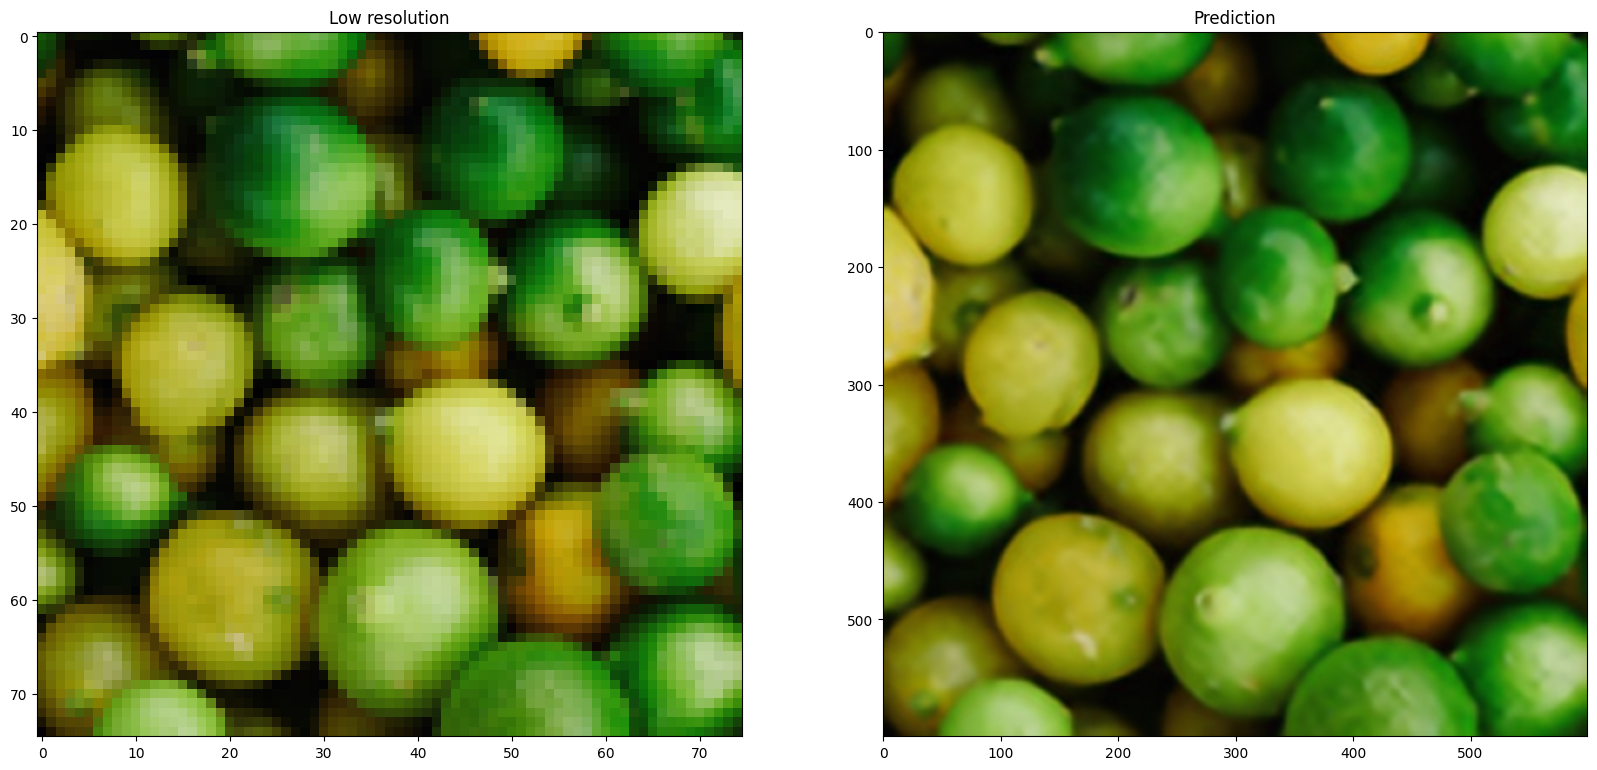

PSNR: 30.280922
SSIM: 0.79016215


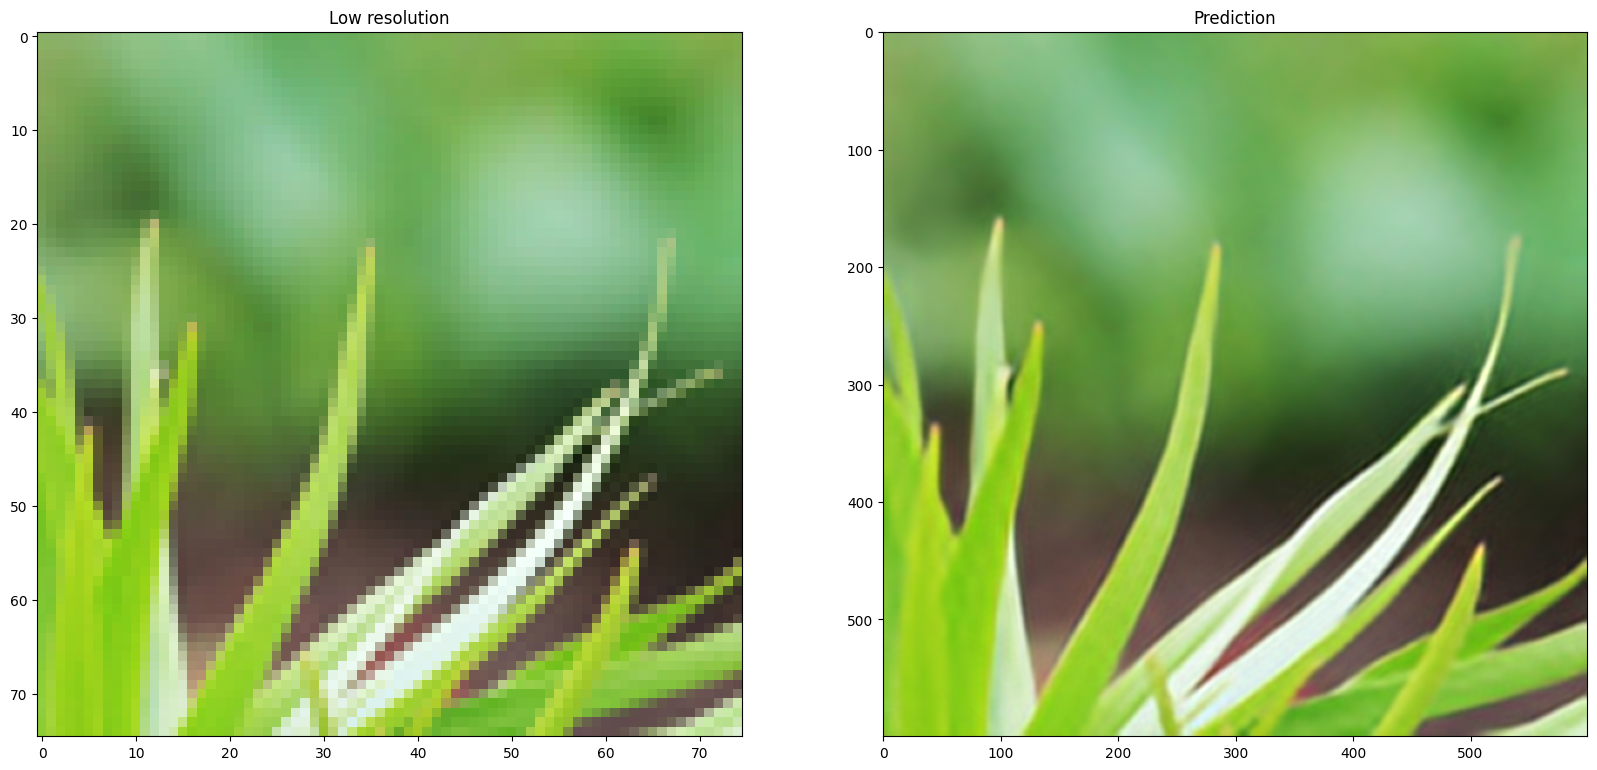

PSNR: 30.012568
SSIM: 0.8944141


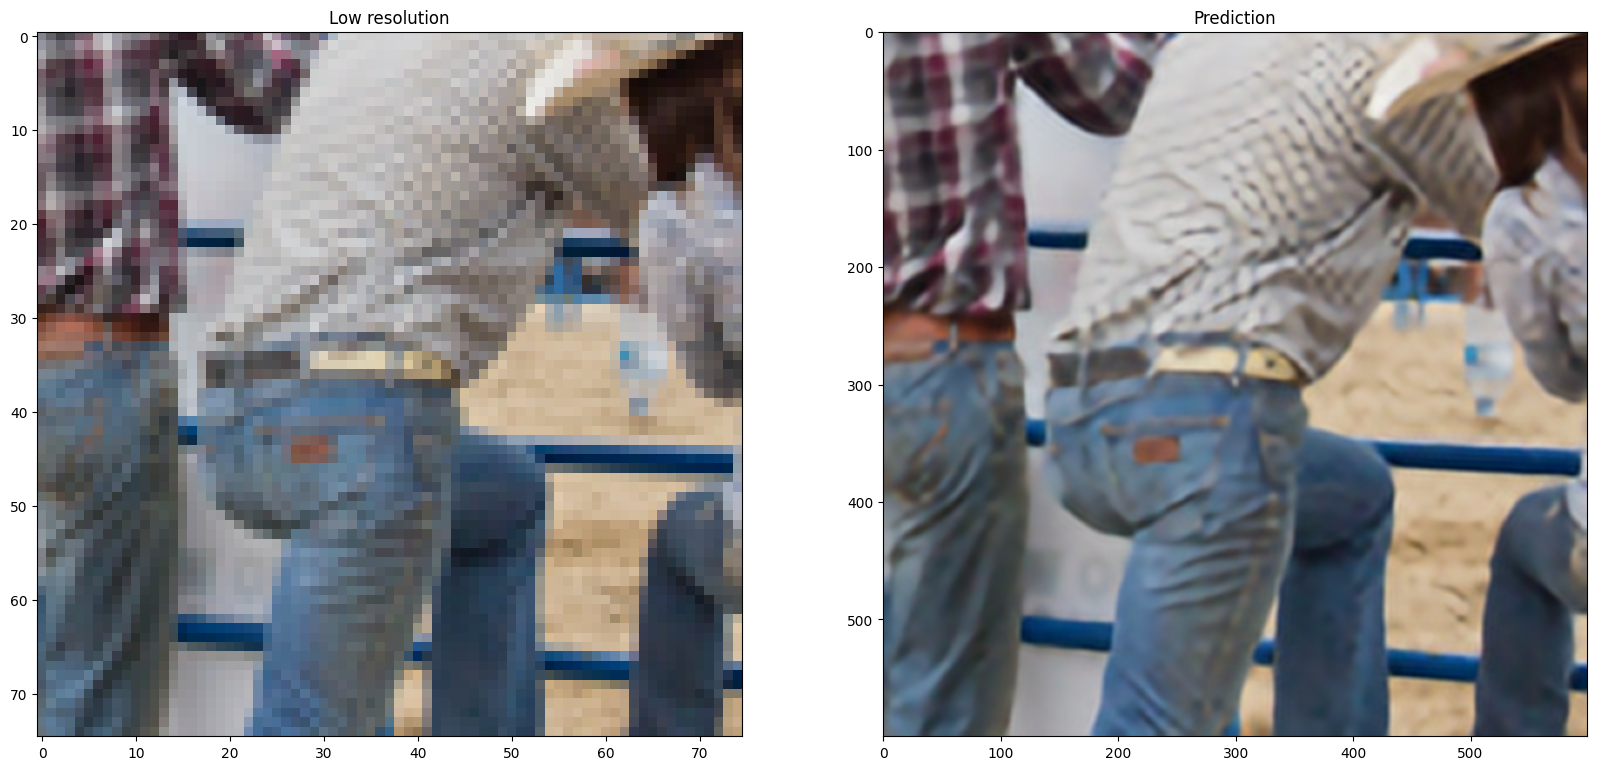

PSNR: 22.38339
SSIM: 0.5155398


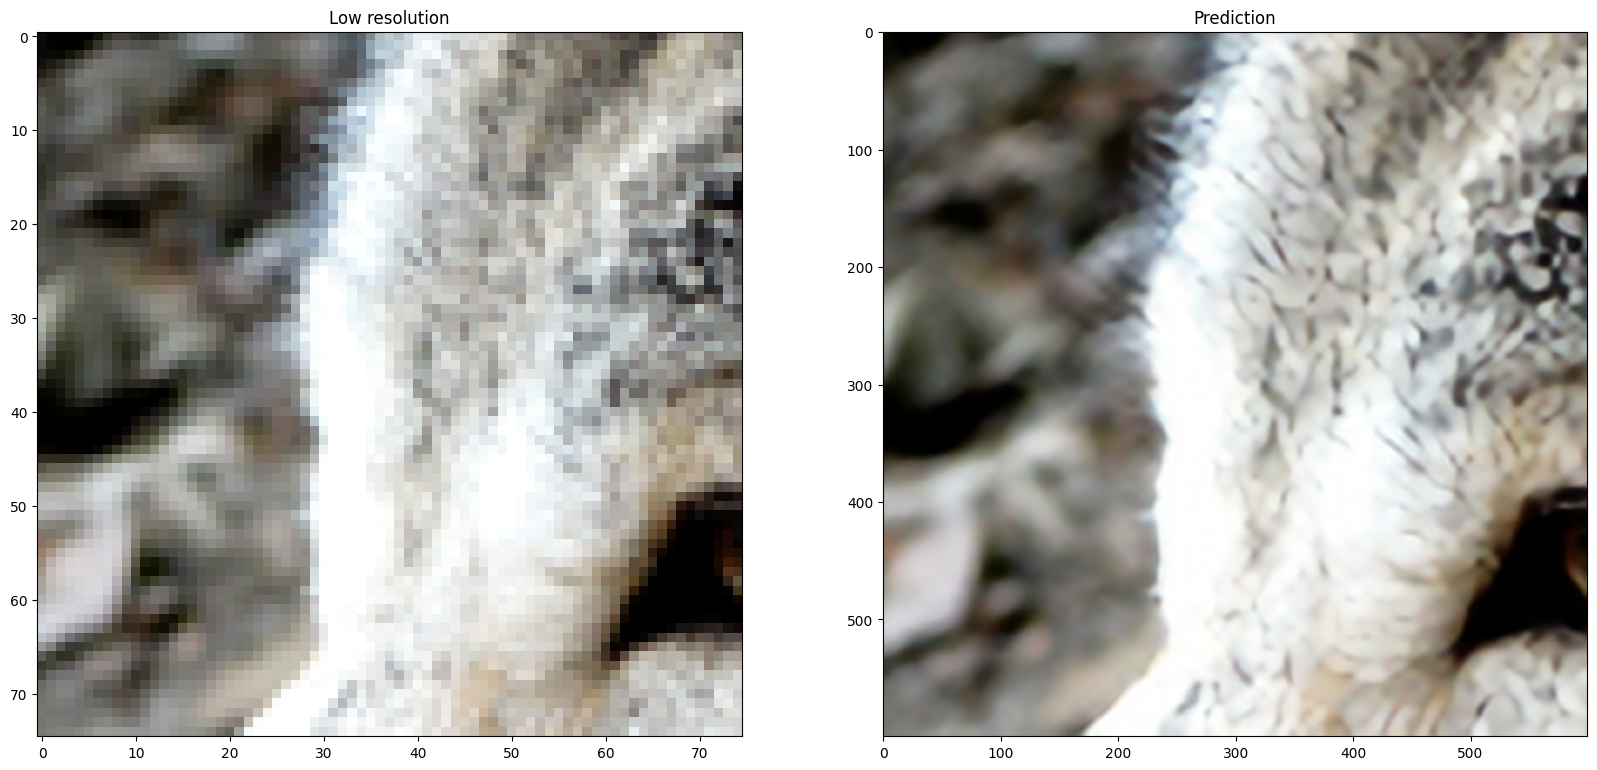

PSNR: 23.71956
SSIM: 0.58156127


In [20]:
# Plotting the Results 

def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(20, 10))
    plt.subplot(121), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(122), plt.imshow(preds), plt.title("Prediction")
    plt.show()

def calculate_psnr(img1, img2):
    psnr = tf.image.psnr(img1, img2, max_val=255)  
    return psnr

def calculate_ssim(img1, img2):
    ssim = tf.image.ssim(img1, img2, max_val=255)  
    return ssim

for lowres, highres in val.take(5):
    lowres, highres = random_crop(lowres, highres, hr_crop_size=600, scale=8)
    preds = model.predict_step(lowres)
    plot_results(lowres, preds)
    psnr_value = calculate_psnr(highres, preds).numpy()
    print("PSNR:", psnr_value)
    ssim_value = calculate_ssim(highres, preds).numpy()
    print("SSIM:", ssim_value)

In [21]:
# Create lists to store PSNR and SSIM values

psnr_values = []
ssim_values = []


for lowres, highres in val:
    lowres, highres = random_crop(lowres, highres, hr_crop_size=600, scale=8)
    preds = model.predict_step(lowres)
    psnr_value = calculate_psnr(highres, preds)
    ssim_value = calculate_ssim(highres, preds)
    
    
    psnr_values.append(psnr_value)
    ssim_values.append(ssim_value)


mean_psnr = np.mean(psnr_values)
mean_ssim = np.mean(ssim_values)

print("Mean PSNR for Validation Dataset:", mean_psnr)
print("Mean SSIM for Validation Dataset:", mean_ssim)

Mean PSNR for Validation Dataset: 24.775328
Mean SSIM for Validation Dataset: 0.6442471


In [ ]:
# This code block is to save a model

model.save_weights('<name to save the file>')